In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import pandas as pd


data = pd.read_csv("/kaggle/input/air-quality-data-in-india/city_day.csv", parse_dates=['Date'])


city = "Delhi"
data = data[data['City'] == city].copy()

cols = ['Date', 'PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2']
data = data[cols].dropna().reset_index(drop=True)

data.head()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2
0,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25
1,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65
2,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65
3,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63
4,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33


In [4]:
#----------AQI computation 
data['AQI'] = (
    0.45 * data['PM2.5'] +
    0.25 * data['PM10'] +
    0.10 * data['NO2'] +
    0.10 * data['SO2'] +
    0.10 * data['CO']
)
data.head()

,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,AQI
0,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,299.0280
1,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,156.0745
2,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,76.5630
3,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,134.0960
4,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,125.4975


In [7]:
day_of_year = data['Date'].dt.dayofyear
seasonal = 15 * np.sin(2 * np.pi * day_of_year / 365)
pollution_effect = 0.12 * data['AQI'] + 0.04 * data['NO2'] + 0.03 * data['SO2']
np.random.seed(42)
noise = np.random.normal(0, 5, len(data))

data['Hospital_Admissions'] = (40 + seasonal + pollution_effect + noise).astype(int)

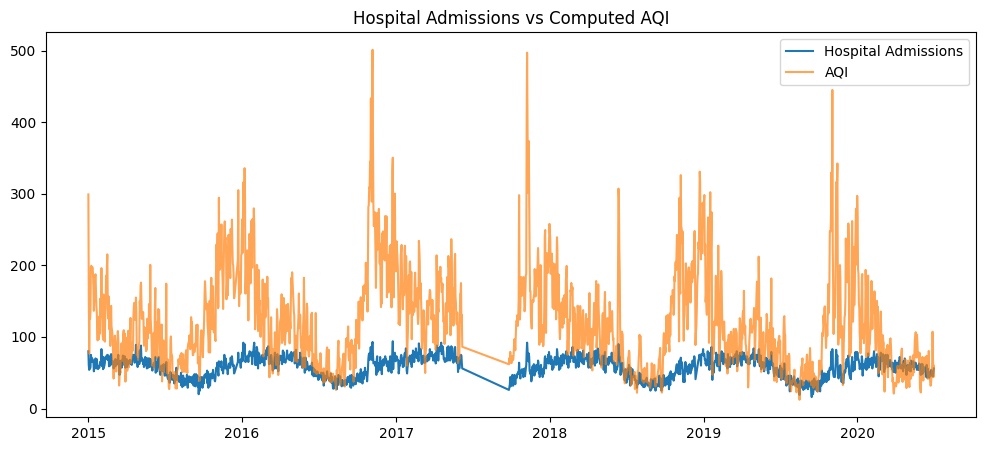

In [8]:
plt.figure(figsize=(12,5))
plt.plot(data['Date'], data['Hospital_Admissions'], label='Hospital Admissions')
plt.plot(data['Date'], data['AQI'], label='AQI', alpha=0.7)
plt.legend(); plt.title('Hospital Admissions vs Computed AQI');
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler



features = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','AQI']
target = ['Hospital_Admissions']


scaler_x = StandardScaler()
scaler_y = StandardScaler()


X_scaled = scaler_x.fit_transform(data[features])
y_scaled = scaler_y.fit_transform(data[target])


data_scaled = np.hstack([X_scaled, y_scaled])

In [10]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, arr, seq_len=90, pred_len=14):
        self.arr = arr.astype(np.float32)
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.arr) - self.seq_len - self.pred_len

    def __getitem__(self, idx):
        x = self.arr[idx:idx+self.seq_len, :-1]  
        y = self.arr[idx+self.seq_len:idx+self.seq_len+self.pred_len, -1:]  
        return torch.tensor(x), torch.tensor(y)

In [11]:
seq_len, pred_len = 90, 14
dataset = TimeSeriesDataset(data_scaled, seq_len, pred_len)

n = len(dataset)
train_size = int(n * 0.7)
val_size = int(n * 0.15)
test_size = n - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [12]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [13]:
dataset = TimeSeriesDataset(data_scaled, seq_len, pred_len)
n = len(dataset)
print("Total windows:", n)
if n <= 0:
    raise RuntimeError("Not enough data for chosen SEQ_LEN and PRED_LEN. Decrease SEQ_LEN or PRED_LEN or provide more data.")

Total windows: 1778


In [15]:
batch_size = 32

train_end = int(n * 0.7)
val_end = int(n * 0.85)
train_indices = list(range(0, train_end))
val_indices = list(range(train_end, val_end))
test_indices = list(range(val_end, n))

from torch.utils.data import Subset
train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print("Splits -> train:", len(train_set), "val:", len(val_set), "test:", len(test_set))

Splits -> train: 1244 val: 267 test: 267


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class DecompBlock(nn.Module):
    """Simple moving average decomposition."""
    def __init__(self, kernel_size=25):
        super().__init__()
        self.kernel_size = kernel_size
        self.pad = kernel_size // 2
        self.avg = nn.AvgPool1d(kernel_size, stride=1, padding=self.pad, count_include_pad=False)

    def forward(self, x):
        trend = self.avg(x.transpose(1,2)).transpose(1,2)
        seasonal = x - trend
        return seasonal, trend

class DecompTransformer(nn.Module):
    def __init__(self, feature_dim=9, d_model=64, nhead=4, num_layers=2, pred_len=14):
        super().__init__()
        self.decomp = DecompBlock(kernel_size=25)
        self.input_proj = nn.Linear(feature_dim, d_model)
        self.pos = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=128, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, pred_len)

    def forward(self, x):
        seasonal, trend = self.decomp(x)
        x = self.input_proj(seasonal + trend)
        x = self.pos(x)
        x = self.transformer(x)
        x = self.fc_out(x.mean(dim=1))
        return x.unsqueeze(-1)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DecompTransformer(feature_dim=9, pred_len=14).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [20]:
epochs = 30
best_val = np.inf
best_epoch = 0

In [22]:
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_losses.append(criterion(pred, yb).item())

    val_mean = np.mean(val_losses)
    print(f"Epoch {epoch+1}/{epochs}  train_loss={np.mean(train_losses):.4f}  val_loss={val_mean:.4f}")

    if val_mean < best_val:
        best_val = val_mean
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pth")
        print("  Saved best model.")

Epoch 1/30  train_loss=0.2421  val_loss=0.4085
Epoch 2/30  train_loss=0.2434  val_loss=0.4386
Epoch 3/30  train_loss=0.2428  val_loss=0.3823
Epoch 4/30  train_loss=0.2411  val_loss=0.3651
Epoch 5/30  train_loss=0.2413  val_loss=0.5185
Epoch 6/30  train_loss=0.2397  val_loss=0.4259
Epoch 7/30  train_loss=0.2373  val_loss=0.4271
Epoch 8/30  train_loss=0.2388  val_loss=0.4393
Epoch 9/30  train_loss=0.2399  val_loss=0.4628
Epoch 10/30  train_loss=0.2350  val_loss=0.3872
Epoch 11/30  train_loss=0.2356  val_loss=0.4085
Epoch 12/30  train_loss=0.2376  val_loss=0.4914
Epoch 13/30  train_loss=0.2316  val_loss=0.4532
Epoch 14/30  train_loss=0.2326  val_loss=0.5204
Epoch 15/30  train_loss=0.2356  val_loss=0.4692
Epoch 16/30  train_loss=0.2302  val_loss=0.4006
Epoch 17/30  train_loss=0.2311  val_loss=0.4597
Epoch 18/30  train_loss=0.2289  val_loss=0.4896
Epoch 19/30  train_loss=0.2324  val_loss=0.4630
Epoch 20/30  train_loss=0.2358  val_loss=0.4463
Epoch 21/30  train_loss=0.2331  val_loss=0.4494
E

Test RMSE: 0.823 | MAE: 0.646


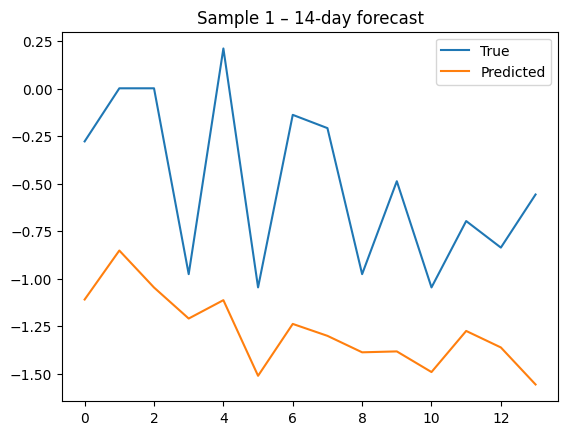

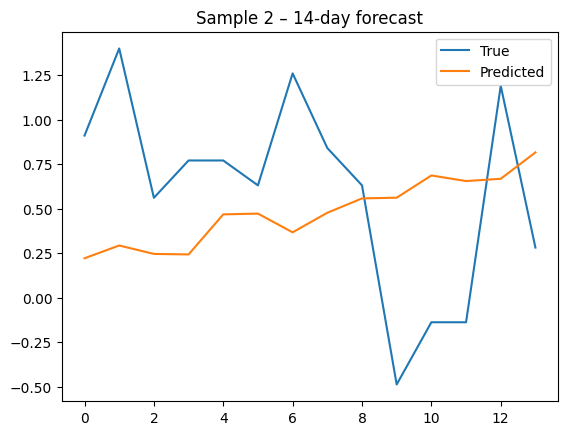

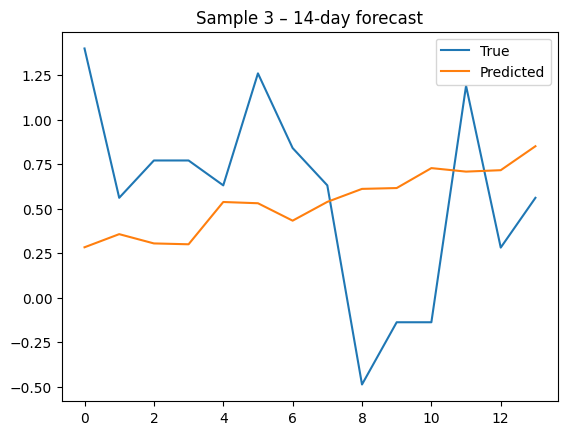

In [25]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb)
        preds.append(pred.cpu().numpy())
        trues.append(yb.numpy())

preds = np.concatenate(preds)
trues = np.concatenate(trues)

rmse = np.sqrt(np.mean((preds - trues)**2))
mae = np.mean(np.abs(preds - trues))
print(f"Test RMSE: {rmse:.3f} | MAE: {mae:.3f}")


for i in range(3):
    idx = np.random.randint(0, len(preds))
    plt.figure()
    plt.plot(trues[idx].flatten(), label="True")
    plt.plot(preds[idx].flatten(), label="Predicted")
    plt.title(f"Sample {i+1} – 14-day forecast")
    plt.legend()
    plt.show()